# Instacart Market Basket Analysis

In [3]:
from constants import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Goal

For each user, we would like to predict which items will be in the user's next order among those that the user has ordered before.

### Data

In [4]:
aisles = pd.read_csv(AISLES)
departments = pd.read_csv(DEPARTMENTS)
order_products_prior = pd.read_csv(ORDER_PRODUCTS_PRIOR)
order_products_train = pd.read_csv(ORDER_PRODUCTS_TRAIN)
orders = pd.read_csv(ORDERS)
products = pd.read_csv(PRODUCTS)

In [5]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [6]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [9]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15
2,473747,1,prior,3,3,12,21
3,2254736,1,prior,4,4,7,29
4,431534,1,prior,5,4,15,28


In [10]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Initial Hypotheses

* The department/aisle of the item as well as the item itself will have a strong effect on when/if it is reordered regardless of any additional information that we can extract from the user's order history.
    * e.g. People that order milk likely reorder milk very frequently.
    * e.g. People that order dish soap probably won't reorder dish soap a week later.
* A user's past history with an item will have a strong effect on when/if it is reordered.
    * e.g. Someone that has ordered milk in every single previous order will likely have milk in their next order.
* There will be customer segments that have different shopping patterns. Some customers may use Instacart to stock up only on basics (paper towels, hand soap, etc) once a month while others may use it every week for all of their grocery needs.
    * Complementary to this is that users who have a regular order cycle (every 7 days, every 14 days, etc) may be more likely to reorder items. If a user has an erratic order schedule, they probably aren't using the service for their regular grocery shopping and thus their orders may be less predictable.
* There will be a strong time component. Certain items may be reoredered every other week while others may be ordered every week.

### Exploratory

In [11]:
train_products = (order_products_train.join(products.set_index("product_id"), 
                                           on = "product_id", how = "inner").
                  join(aisles.set_index("aisle_id"), on = "aisle_id", how = "inner").
                  join(departments.set_index("department_id"), on = "department_id", 
                                             how = "inner"))

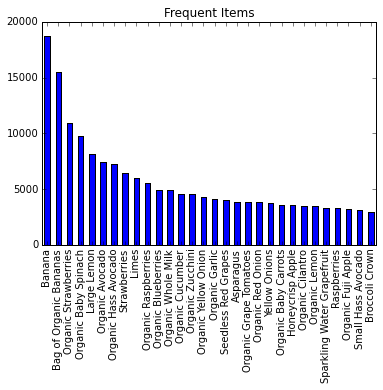

In [12]:
train_products.product_name.value_counts().head(30).plot(kind = "bar", 
                                                         title = "Frequent Items")

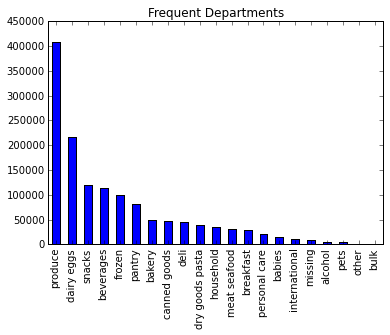

In [13]:
train_products.department.value_counts().plot(kind = "bar", title = "Frequent Departments")

Produce items are by far the most frequently ordered. The produce department is nearly twice as large as the next largest one which is dairy and eggs.

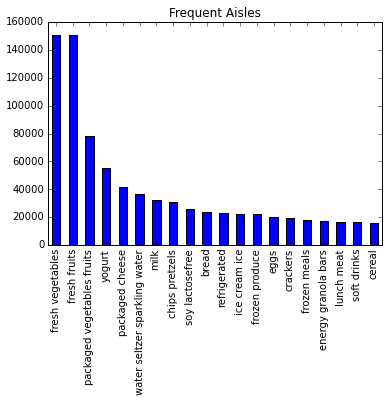

In [14]:
train_products.aisle.value_counts().head(20).plot(kind = "bar", title = "Frequent Aisles")

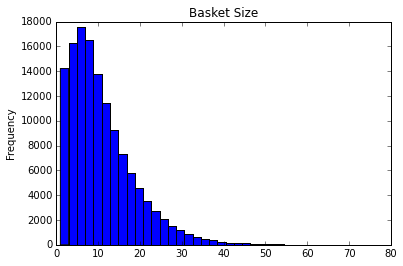

In [15]:
train_products.groupby("order_id").size().plot(kind = "hist", title = "Basket Size", bins = 40)

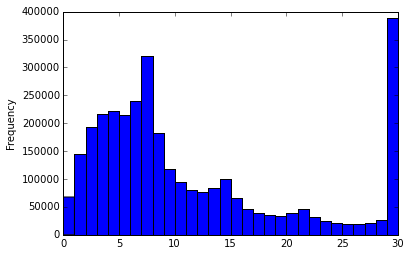

In [24]:
orders.days_since_prior_order.plot(kind = "hist", bins = 30, title = "Gap Between Orders")

There are peaks in the order gaps at 7, 14, and 21 days. These people are probably the users that are most likely to have the strongest routine and order predictability.

There is a huge peak at 30, so the order gap must be capped at 30. In other words, if your gap between orders is greater than or equal to 30, it shows up as 30.

### Approaches

I will frame this a binary classification problem where I predict ordered/not ordered given a ('user_id', 'product_id') pair for all products that the user has ordered in the past.

I will first generate the training set (without features). For every "user_id"/"order_id" in the train "eval_set", this dataframe will have a row for every product that this user has ordered in prior orders. Thus, it will have attributes ("user_id", "order_id", "product_id") and the binary response "ordered" indicating whether this product was in the order.

In [17]:
joined_order_products = (orders[orders.eval_set == "train"]
                         .join(orders[orders.eval_set == "prior"].set_index("user_id"), on = "user_id", 
                               rsuffix = "_prior")
                         .join(order_products_prior.set_index("order_id"), on = "order_id_prior"))

In [18]:
training_set_no_features = (joined_order_products[["user_id", "order_id", "product_id"]]
                            .reset_index()
                            .drop_duplicates()
                            .join(order_products_train.set_index(["order_id", "product_id"]), 
                                  on = ["order_id", "product_id"], how = "left")
                            .rename(columns = {"reordered": "ordered"})
                            [["user_id", "order_id", "product_id", "ordered"]])

In [19]:
training_set_no_features.ordered = (training_set_no_features.ordered
                                    .apply(lambda x: 0 if np.isnan(x) else 1))

In [20]:
training_set_no_features.head()

,user_id,order_id,product_id,ordered
0,1,1187899,196,1
1,1,1187899,14084,0
2,1,1187899,12427,0
3,1,1187899,26088,1
4,1,1187899,26405,1


In [21]:
product_reorder_rate = (training_set_no_features
                        .groupby("product_id")
                        .agg({"ordered": ["mean", "count"]}))

In [22]:
(product_reorder_rate[product_reorder_rate.ordered["count"] > 200]
 .join(products.set_index("product_id"), how = "inner")
 .sort_values(by = ("ordered", "mean"), ascending = False)
 .head(20)
)

,"(ordered, mean)","(ordered, count)",product_name,aisle_id,department_id
product_id,,,,,
39276,0.401062,753,Bananas,24,4
20940,0.363636,924,Organic Low Fat Milk,84,16
24852,0.352547,46964,Banana,24,4
44177,0.342105,304,Large Grade A Eggs,86,16
1729,0.339921,253,2% Lactose Free Milk,84,16
13176,0.329983,40493,Bag of Organic Bananas,24,4
45504,0.313341,817,Whole Organic Omega 3 Milk,84,16
38689,0.311872,3386,Organic Reduced Fat Milk,84,16
43394,0.303714,754,Organic Lactose Free Whole Milk,91,16


Milk, bananas, and eggs dominate the most frequently reordered items list. However, out of all customers who had ordered these items in the past, no more than 40% had them in their next order. In other words, item alone isn't sufficient to predict.

There are a significant number of items that are near duplicates. For example, Organic Low Fat Milk and 2% Lactose Free Milk. When learning people's milk buying habits it probably doesn't matter what type of milk they buy, so I may want to find a way to group similar items. Perhaps aisle would be sufficient for that task, but I can also think about getting a vector representation of products using something like word2vec.

### Features

#### User

User level features attempt to capture behavior of different types of users (e.g. regular weekly order schedule, irregular small orders, etc.).
* Total number of orders
* Order frequency stats
    * Mean, mode, sd of time between orders
* Order size stats
    * Mean products per order
* Reorder rate
    * Overall rate: number of reordered products divided by total number of ordered products
    * Distinct rate: number of distinct reordered products divided by total number of distinct ordered products

#### Product

Product level features attempt to describe properties of products (e.g. popular staple products like milk that are often reordered, obscure products like spices that are hardly ever reordered, etc.).
* Total number of product orders
* Reorder Rate
    * Total number of product reorders divided by total number of product orders
    * Mean number of reorders per user: total reorders divided by distinct users that have ordered product
    * Initial reorder rate: proportion of users with at least two orders and one order of the product who have reordered product
* Position stats
    * Mean and mode position in cart 

#### Order

Order level features describe the general information about the order.
* Days since last order
* Last order size
* Day of the week

#### User-Product

User-Product features attempt to capture a user's behavior with respect to a product.
* Total number of reorders
* Order rate
    * Global: total number of user product orders divided by total number of user orders
    * Since first order: total number of reorders divided by number of orders after first order of product
* Last order of product
    * User had product in most recent order (0/1)
    * Days since last order of product
    * Orders since last order of product
    * Day of week of last order
* Day gap between last two orders of product